# Randomized Image Sampling for Explanations (RISE)

In [46]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import torchvision.models as models

from utils import *
from explanations import *


In [47]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torchvision as tvis
import time
from utils import *
cudnn.benchmark = True

In [48]:
### Load the dataset

In [49]:
input_size = (224, 224)
batch_size = 16
feature_extract=True

In [50]:
transform = {
        'train': transforms.Compose(
            [   
                transforms.Resize([230, 230]),
                transforms.RandomAffine(degrees=[-60, 60], ),
                transforms.RandomCrop(input_size[0]),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.2, 
                                                   contrast=0.2, 
                                                   saturation=0.2, 
                                                   hue=0.1),
                
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'test': transforms.Compose(
            [transforms.Resize(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
        }

target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x, dtype=torch.int64), 2)

In [51]:
data_folder = "/home/guest/mabdelfa/zerowaste/data/zerowaste-w/"
dataset = datasets.ImageFolder(root = data_folder, transform=transform['train'],
                              target_transform=target_transform)

validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [52]:
print(dataset.class_to_idx)

{'after': 0, 'before': 1}


In [53]:
img, labels = next(iter(validation_loader))
print()

"""
for i in range(5):
    print(labels[i])
    plt.imshow(img[i].permute((1, 2, 0)))
    plt.show()
"""

'\nfor i in range(5):\n    print(labels[i])\n    plt.imshow(img[i].permute((1, 2, 0)))\n    plt.show()\n'

### Define the model

In [54]:
model = models.resnet50(True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = nn.Sequential(model, nn.Softmax())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= nn.DataParallel(model)
model = model.to(device)


/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 2. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [55]:
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer_ft, gamma=0.9)

Params to learn:
	 module.0.conv1.weight
	 module.0.bn1.weight
	 module.0.bn1.bias
	 module.0.layer1.0.conv1.weight
	 module.0.layer1.0.bn1.weight
	 module.0.layer1.0.bn1.bias
	 module.0.layer1.0.conv2.weight
	 module.0.layer1.0.bn2.weight
	 module.0.layer1.0.bn2.bias
	 module.0.layer1.0.conv3.weight
	 module.0.layer1.0.bn3.weight
	 module.0.layer1.0.bn3.bias
	 module.0.layer1.0.downsample.0.weight
	 module.0.layer1.0.downsample.1.weight
	 module.0.layer1.0.downsample.1.bias
	 module.0.layer1.1.conv1.weight
	 module.0.layer1.1.bn1.weight
	 module.0.layer1.1.bn1.bias
	 module.0.layer1.1.conv2.weight
	 module.0.layer1.1.bn2.weight
	 module.0.layer1.1.bn2.bias
	 module.0.layer1.1.conv3.weight
	 module.0.layer1.1.bn3.weight
	 module.0.layer1.1.bn3.bias
	 module.0.layer1.2.conv1.weight
	 module.0.layer1.2.bn1.weight
	 module.0.layer1.2.bn1.bias
	 module.0.layer1.2.conv2.weight
	 module.0.layer1.2.bn2.weight
	 module.0.layer1.2.bn2.bias
	 module.0.layer1.2.conv3.weight
	 module.0.layer1.2.bn

In [56]:
criterion = torch.nn.BCELoss()
dataloaders_dict = {"train": train_loader, "val": validation_loader}

In [57]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 1.

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_samples = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.to(torch.float32)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    labels.data = labels.data
                    loss = criterion(outputs, labels.data)
                    preds = (outputs > 0.5).type(torch.cuda.FloatTensor)
                   
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.mean(torch.abs(preds - labels.data))
                num_samples += 1

            epoch_loss = running_loss / batch_size * num_samples
            epoch_acc = running_corrects.double() / num_samples

            print('{} Loss: {:.4f} MSE: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc < best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            
            #scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val MSE: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [58]:
train_from_scratch = False
ckpt_path = "binary_classifier.pt"

if train_from_scratch:
    model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=4)
    torch.save(model_ft.state_dict(), ckpt_path)
else:
    model.load_state_dict(torch.load(ckpt_path))

In [59]:
for p in model.parameters():
    p.requires_grad = False
model.eval()

DataParallel(
  (module): Sequential(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace

In [60]:

for img, labels in dataloaders_dict["val"]:
    img = img.to(device)
    labels = labels.to(device)
    outputs = model(img)
    preds = (outputs > 0.5).type(torch.cuda.FloatTensor)
    print(preds[:5])
    print(labels.data[0:5])
    break

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]], device='cuda:0')
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], device='cuda:0')
/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


---

## RISE

In [61]:
#model = nn.DataParallel(model)

In [62]:
explainer = RISE(model, input_size, batch_size)

In [63]:

maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=3000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')


Generating filters: 100%|██████████| 3000/3000 [00:06<00:00, 448.90it/s]


---

## Running explanations

In [64]:
def class_name(idx):
    return "after" if idx == 0 else "before"

In [65]:
import PIL
from PIL import Image

def load_img(path):
    img = Image.open(path).resize(input_size, PIL.Image.BILINEAR)
    x = np.asarray(img)
    x = np.expand_dims(x, axis=0)
    return x

In [66]:
def example(img, top_k=2):
    saliency = explainer(img.cuda()).cpu().numpy()
    p, c = torch.topk(model(img.cuda()), k=2)
    p, c = p[0], c[0]
    
   
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('%.2f %s' % (100*float(p[k]),
                                     class_name(int(c[k]))))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(class_name(int(c[k])))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

In [67]:
img_file = "/home/guest/mabdelfa/zerowaste/data/zerowaste-w/before/01_frame_004640.PNG"
pred = (model(read_tensor(img_file).cuda()) > 0.5)[0]

print(pred)

tensor([False,  True], device='cuda:0')


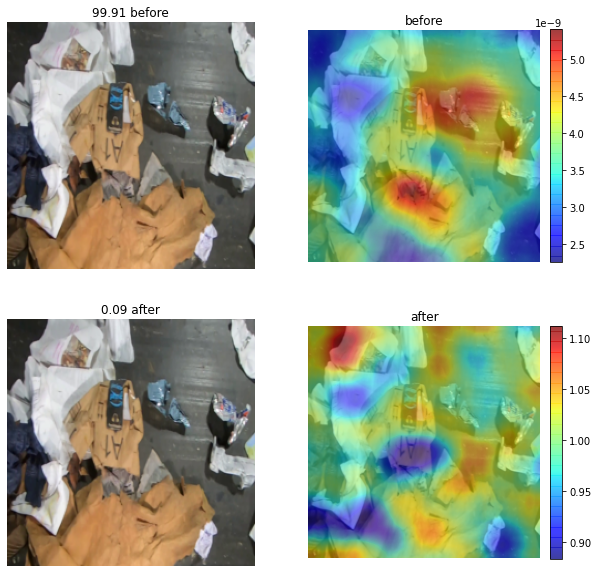

In [68]:
#example(read_tensor(img_file), 2)

In [69]:
def explain_all(data_loader, explainer):
    # Get all predicted labels first
    target = np.empty(len(data_loader), np.int)
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Predicting labels')):
        p, c = torch.max(model(img.cuda()), dim=1)
        target[i] = c[0]

    # Get saliency maps for all images in val loader
    explanations = np.empty((len(data_loader), *input_size))
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Explaining images')):
        saliency_maps = explainer(img.cuda())
        explanations[i] = saliency_maps[target[i]].cpu().numpy()
    return explanations

In [70]:
rangee = range(95, 105)
n_batch = 1

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=n_batch, shuffle=False,
    num_workers=8, pin_memory=True, sampler=RangeSampler(rangee))

#explanations = explain_all(data_loader, explainer)


In [71]:
 def explain_all_batch(data_loader, explainer):
     n_batch = len(data_loader)
     b_size = data_loader.batch_size
     total = n_batch * b_size
     # Get all predicted labels first
     target = np.empty(total, 'int64')
     for i, (imgs, _) in enumerate(tqdm(data_loader, total=n_batch, desc='Predicting labels')):
         p, c = torch.max(nn.Softmax(1)(explainer.model(imgs.cuda())), dim=1)
         target[i * b_size:(i + 1) * b_size] = c.cpu()
     image_size = imgs.shape[-2:]
     count = 0

     # Get saliency maps for all images in val loader
     explanations = np.empty((total, *image_size))
     for i, (imgs, _) in enumerate(tqdm(data_loader, total=n_batch, desc='Explaining images')):
         saliency_maps = explainer(imgs.cuda())
         explanations[i * b_size:(i + 1) * b_size] = saliency_maps[
             range(b_size), target[i * b_size:(i + 1) * b_size]].data.cpu().numpy()
     return explanations

In [72]:
#explainer = RISEBatch(model, input_size, batch_size)

In [73]:
"""
maskspath = 'masks_for_batch.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=3000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')
"""

"\nmaskspath = 'masks_for_batch.npy'\ngenerate_new = True\n\nif generate_new or not os.path.isfile(maskspath):\n    explainer.generate_masks(N=3000, s=8, p1=0.1, savepath=maskspath)\nelse:\n    explainer.load_masks(maskspath)\n    print('Masks are loaded.')\n"

In [74]:
imgs_per_batch = 2

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=imgs_per_batch, shuffle=False,
    num_workers=8, pin_memory=True)

#explanations = explain_all_batch(data_loader, explainer)

#explanations.tofile('my_explanations.npy')

In [75]:
#explanations.tofile('exp_{:05}-{:05}.npy'.format(rangee[0], rangee[-1]))

In [76]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d

from utils import *
from evaluation import CausalMetric, auc, gkern
from explanations import *

cudnn.benchmark = True

In [77]:

klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)


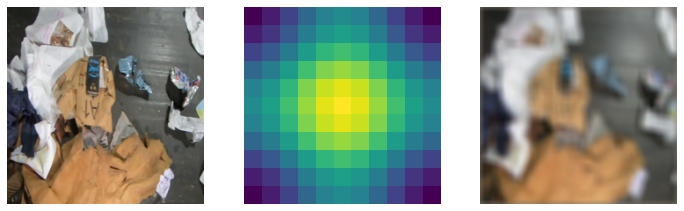

In [78]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('/home/guest/mabdelfa/zerowaste/data/zerowaste-w/before/01_frame_004640.PNG')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [79]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

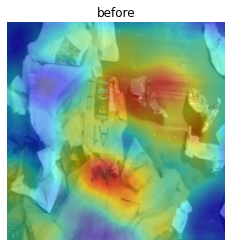

In [80]:
sal = explainer(img.cuda())[1].cpu().numpy()

tensor_imshow(img[0])
plt.axis('off')
plt.title(class_name(1))
plt.imshow(sal, cmap='jet', alpha=0.5)
plt.show()

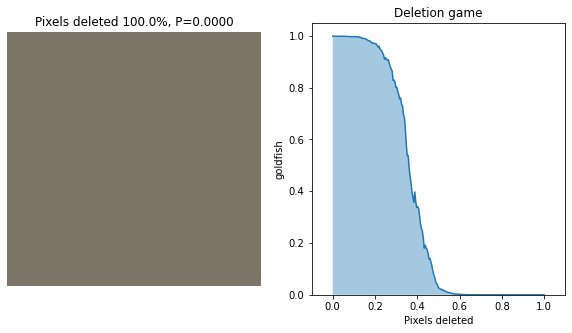

In [81]:
h = deletion.single_run(img, sal, verbose=1)

/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


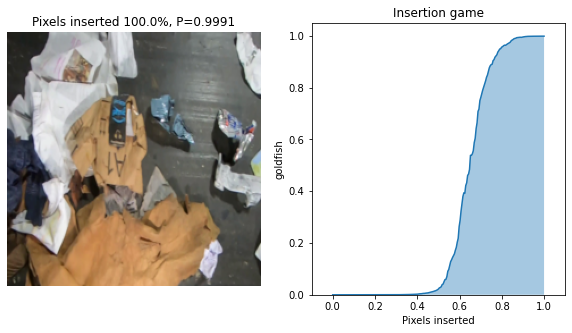

In [82]:
h = insertion.single_run(img, sal, verbose=1)

In [95]:
insertion = CausalMetric(model, 'ins', 224 * 8, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224 * 8, substrate_fn=torch.zeros_like)

scores = {'del': [], 'ins': []}

for i in range(2):
    # Load batch of images
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=250, shuffle=False,
        num_workers=8, pin_memory=True, sampler=RangeSampler(range(3000 * i, 3000 * (i + 1))))

    images = np.empty((len(data_loader), 250, 3, 224, 224))
    for j, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Loading images')):
        images[j] = img
    images = images.reshape((-1, 3, 224, 224))

    exp = np.fromfile('my_explanations.npy').reshape((3000, 224, 224))
    
    h = deletion.evaluate(torch.from_numpy(images.astype('float32')), exp, 100)
    scores['del'].append(auc(h.mean(1)))

    # Evaluate insertion
    h = insertion.evaluate(torch.from_numpy(images.astype('float32')), exp, 100)
    scores['ins'].append(auc(h.mean(1)))

print('----------------------------------------------------------------')
print('Final:\nDeletion - {:.5f}\nInsertion - {:.5f}'.format(np.mean(scores['del']), np.mean(scores['ins'])))

Loading images:  75%|███████▌  | 9/12 [00:28<00:09,  3.20s/it]


IndexError: Caught IndexError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torchvision/datasets/folder.py", line 177, in __getitem__
    path, target = self.samples[index]
IndexError: list index out of range
